In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-31,335.500000,341.489990,321.040009,323.470001,323.470001,8535100
1,2017-08-01,323.000000,324.450012,316.130005,319.570007,319.570007,8303100
2,2017-08-02,318.940002,327.119995,311.220001,325.890015,325.890015,13091500
3,2017-08-03,345.329987,350.000000,343.149994,347.089996,347.089996,13535000
4,2017-08-04,347.000000,357.269989,343.299988,356.910004,356.910004,9268900


In [4]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [5]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [6]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [9]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(10, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [10]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [11]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'size_network': 965, 'window_size': 45, 'population_size': 35, 'skip': 12, 'learning_rate': 0.20812911817036672, 'sigma': 0.9085617370780164}
time taken to train: 9.127995014190674 seconds
stop after 500 iteration with investment 4.781100
    1 | 00m09s |    4.78110 |          0.2081 |           35.3435 |    0.9086 |       964.6260 |   12.0911 |       44.6417 | 

Search parameters {'size_network': 171, 'window_size': 33, 'population_size': 44, 'skip': 12, 'learning_rate': 0.2543689544854069, 'sigma': 0.32876073755283014}
time taken to train: 2.5704901218414307 seconds
stop after 500 iteration with investment 8.530600
    2 | 00m02s |    8.53060 |          0.2544 |           43.8516 |    0.3288 |       170

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


stop after 500 iteration with investment 0.000000
    3 | 00m00s |    0.00000 |          0.3631 |           14.5608 |    0.0667 |       646.0338 |    3.5228 |        9.4381 | 

Search parameters {'size_network': 871, 'window_size': 5, 'population_size': 19, 'skip': 14, 'learning_rate': 0.2565872257604924, 'sigma': 0.3936407767103818}
time taken to train: 1.0878596305847168 seconds
stop after 500 iteration with investment 7.360502
    4 | 00m01s |    7.36050 |          0.2566 |           18.8311 |    0.3936 |       870.7867 |   14.1011 |        4.9752 | 

Search parameters {'size_network': 317, 'window_size': 4, 'population_size': 48, 'skip': 3, 'learning_rate': 0.1573589486643058, 'sigma': 0.5051669694485229}
time taken to train: 4.5775306224823 seconds
stop after 500 iteration with investment 14.285701
    5 | 00m04s |   14.28570 |          0.1574 |           48.0568 |    0.5052 |       317.1404 |    3.3509 |        3.5796 | 

Search parameters {'size_network': 232, 'window_size': 44,

stop after 500 iteration with investment 0.000000
   25 | 00m01s |    0.00000 |          0.3708 |           49.5414 |    0.2001 |       871.5092 |   13.6096 |        8.2158 | 

Search parameters {'size_network': 421, 'window_size': 21, 'population_size': 9, 'skip': 14, 'learning_rate': 0.25976543883201275, 'sigma': 0.9725216158425024}
time taken to train: 0.646111011505127 seconds
stop after 500 iteration with investment 4.305499
   26 | 00m00s |    4.30550 |          0.2598 |            9.1358 |    0.9725 |       421.0735 |   14.3967 |       21.4845 | 

Search parameters {'size_network': 284, 'window_size': 12, 'population_size': 10, 'skip': 6, 'learning_rate': 0.020358001425177755, 'sigma': 0.9197175163542975}
time taken to train: 0.706169843673706 seconds
stop after 500 iteration with investment -1.747999
   27 | 00m00s |   -1.74800 |          0.0204 |           10.0361 |    0.9197 |       284.2565 |    6.0083 |       12.1130 | 

Search parameters {'size_network': 692, 'window_size'

stop after 500 iteration with investment 0.000000
   46 | 00m01s |    0.00000 |          0.3721 |           10.5887 |    0.1945 |       109.5451 |    6.0076 |       28.4630 | 

Search parameters {'size_network': 461, 'window_size': 36, 'population_size': 28, 'skip': 9, 'learning_rate': 0.061676407561564, 'sigma': 0.3563517422123184}
time taken to train: 3.9091644287109375 seconds
stop after 500 iteration with investment 7.832001
   47 | 00m04s |    7.83200 |          0.0617 |           27.7358 |    0.3564 |       461.4185 |    9.4074 |       36.1291 | 

Search parameters {'size_network': 607, 'window_size': 8, 'population_size': 9, 'skip': 2, 'learning_rate': 0.306617584841014, 'sigma': 0.5687996807759338}
time taken to train: 1.670348882675171 seconds
stop after 500 iteration with investment 33.201499
   48 | 00m02s |   33.20150 |          0.3066 |            9.0855 |    0.5688 |       606.9883 |    2.2248 |        8.3144 | 

Search parameters {'size_network': 390, 'window_size': 44, 

   68 | 00m03s |   -0.76820 |          0.0539 |           43.2069 |    0.6712 |       649.5645 |    9.6053 |        4.4240 | 

Search parameters {'size_network': 441, 'window_size': 27, 'population_size': 3, 'skip': 3, 'learning_rate': 0.16304674397378732, 'sigma': 0.10811409306536884}
stop after 500 iteration with investment 0.000000
   69 | 00m01s |    0.00000 |          0.1630 |            2.8793 |    0.1081 |       440.9811 |    2.8290 |       27.2369 | 

Search parameters {'size_network': 894, 'window_size': 30, 'population_size': 30, 'skip': 5, 'learning_rate': 0.46175970281455464, 'sigma': 0.7752735597676016}
time taken to train: 7.832126140594482 seconds
stop after 500 iteration with investment 22.597998
   70 | 00m08s |   22.59800 |          0.4618 |           29.7216 |    0.7753 |       893.9025 |    4.9908 |       30.1173 | 

Search parameters {'size_network': 642, 'window_size': 42, 'population_size': 28, 'skip': 11, 'learning_rate': 0.4490886103156396, 'sigma': 0.215676856

In [12]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 58.273906
Best AGENT parameters:  {'size_network': 175.6884650775251, 'window_size': 20.49784121062309, 'sigma': 0.7152490670931403, 'population_size': 33.54835524216057, 'learning_rate': 0.28208006704411104, 'skip': 1.2806149560030797}


In [14]:
# this is my parameter
best_agent(30, 1, 15, 0.1, 0.03, 500)

time taken to train: 8.902231216430664 seconds


44.664403540000016

In [15]:
# this is from bayesian
best_agent(20, 1, 34, 0.7152490670931403, 0.28208006704411104, 176)

time taken to train: 11.191874265670776 seconds


54.70499670999992

iter 100. reward: 63.307998
iter 200. reward: 68.621898
iter 300. reward: 81.728899
iter 400. reward: 85.140902
iter 500. reward: 87.653898
time taken to train: 41.50784707069397 seconds
day 0: buy 5 units at price 1617.350005, total balance 8382.649995
day 1: buy 5 units at price 1597.850035, total balance 6784.799960
day 2: buy 5 units at price 1629.450075, total balance 5155.349885
day 3: buy 5 units at price 1735.449980, total balance 3419.899905
day 4, sell 5 units at price 1784.550020, investment 10.337899 %, total balance 5204.449925,
day 5, sell 5 units at price 1775.850065, investment 11.139971 %, total balance 6980.299990,
day 6, sell 5 units at price 1826.100005, investment 12.068485 %, total balance 8806.399995,
day 7, sell 5 units at price 1817.649995, investment 4.736525 %, total balance 10624.049990,
day 14: buy 5 units at price 1737.299955, total balance 8886.750035
day 15: buy 5 units at price 1689.299925, total balance 7197.450110
day 19: buy 5 units at price 1740.249

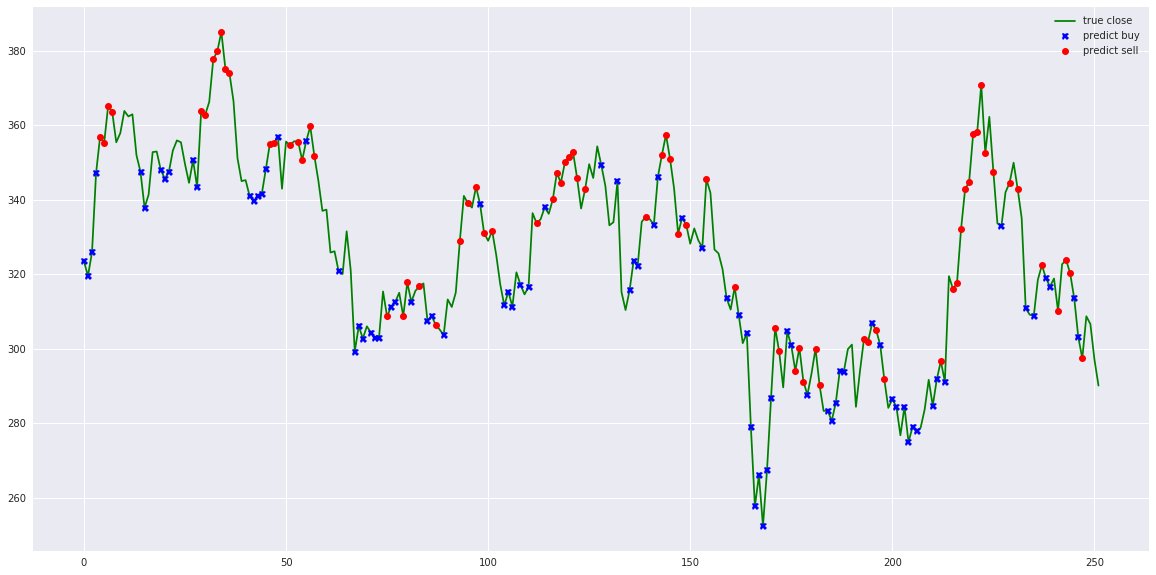

In [16]:
# this is my parameter
model = Model(30, 500, 3)
agent = Agent(15, 0.1, 0.03, model, 10000, 5, 5, 1, 30)
agent.fit(500, 100)
agent.buy()

iter 100. reward: 64.774399
iter 200. reward: 77.959298
iter 300. reward: 88.457299
iter 400. reward: 90.379699
iter 500. reward: 91.761199
time taken to train: 55.998340368270874 seconds
day 0: buy 5 units at price 1617.350005, total balance 8382.649995
day 1: buy 5 units at price 1597.850035, total balance 6784.799960
day 3, sell 5 units at price 1735.449980, investment 7.302067 %, total balance 8520.249940,
day 4, sell 5 units at price 1784.550020, investment 11.684450 %, total balance 10304.799960,
day 14: buy 5 units at price 1737.299955, total balance 8567.500005
day 15: buy 5 units at price 1689.299925, total balance 6878.200080
day 16: buy 5 units at price 1706.750030, total balance 5171.450050
day 17: buy 5 units at price 1763.849945, total balance 3407.600105
day 18: buy 5 units at price 1764.649965, total balance 1642.950140
day 19: buy 5 units at price 1740.249940, total balance -97.299800
day 24, sell 5 units at price 1776.999970, investment 2.285156 %, total balance 1679.

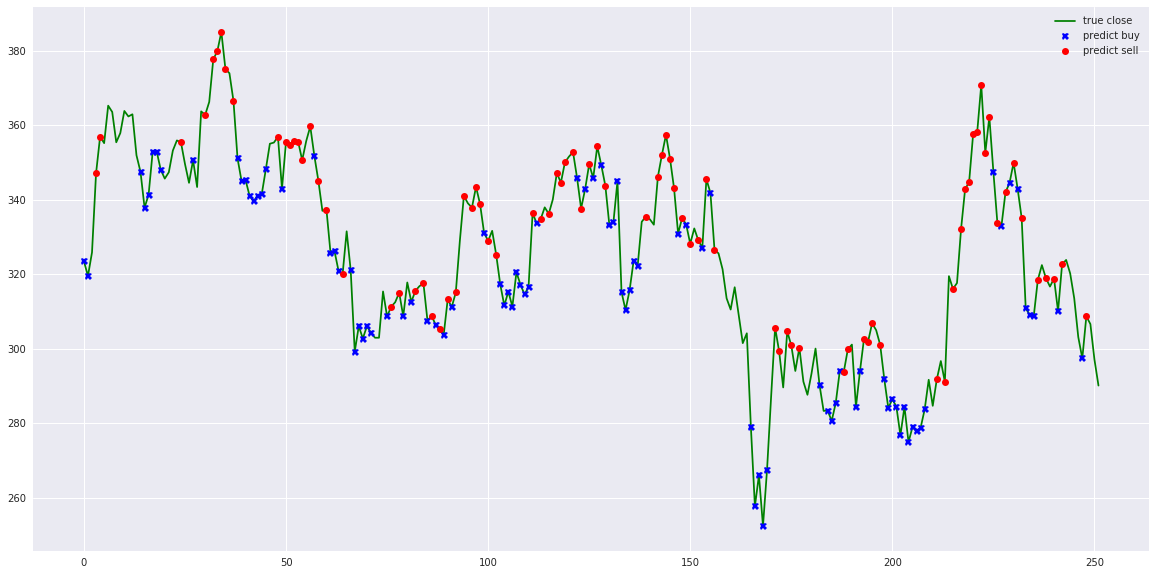

In [17]:
# this is from bayesian
model = Model(20, 176, 3)
agent = Agent(
    34, 0.7152490670931403, 0.28208006704411104, model, 10000, 5, 5, 1, 20
)
agent.fit(500, 100)
agent.buy()